# Higgs boson data preparation for machine learning exercise
 >__Created__:  2018 Harrison B. Prosper, updated 25 June 2018 for ESHEP 18.


In [2]:
import os, sys
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

import matplotlib as mp
import matplotlib.pyplot as plt
import pylab as pl

%matplotlib inline

### Function to unweight weighted data using a bootstrap method

In [3]:
def bootstrap_unweight(df, weightname='weight'):
    from math import sqrt
    from random import uniform
    
    def binsearch(L, item):
        first = 0
        last  = len(L) - 1   
        found = False
        while (first <= last) and not found:
            mid = (first + last) / 2
            if item <= L[mid]:
                last = mid;       
            elif item > L[mid]:
                first = mid + 1
            if first >= last:
                mid = first
                found = True
        if found: return mid
        return -1

    w1 = df[weightname]
    w2 = w1*w1
    w1sum = sum(w1)
    w2sum = sum(w2)
    count = int(w1sum*w1sum / w2sum)
    wcdf  = np.cumsum(w1)
    print "summed weight sum: %10.4f" % w1sum
        
    wlist = wcdf.tolist()
    index = []
    for i in xrange(count):
        w = uniform(0, w1sum)
        k = binsearch(wlist, w)
        if k < 0 or k > len(wlist)-1:
            print "**error** location of weight %f not found" % w
            return None
        index.append(k)
    return df.iloc[index]

In [4]:
# update fonts
FONTSIZE = 32
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 28}

mp.rc('font', **font)

### Read data into memory
  * Read data sets into memory
  * Add a target column to each dataframe for later use. 

In [5]:
sig = pd.read_csv('data/hzz_vbf.csv')
sig['target'] = np.ones(len(sig))

bkg = pd.read_csv('data/hzz_ggf.csv')
bkg['target'] = np.zeros(len(bkg))
names = sig.keys()

### Split into testing and training data samples

In [6]:
test_fraction = 0.20
sig_train_data, sig_test_data = train_test_split(sig, test_size=test_fraction)
bkg_train_data, bkg_test_data = train_test_split(bkg, test_size=test_fraction)

print "sig data"
print sig_train_data.shape, sig_test_data.shape
print

print "bkg data"
print bkg_train_data.shape, bkg_test_data.shape


sig data
(50135, 10) (12534, 10)

bkg data
(46416, 10) (11604, 10)


### Unweight data
  * Use a bootstrap technique to unweight data.

In [7]:
sig_train = bootstrap_unweight(sig_train_data)
sig_test  = bootstrap_unweight(sig_test_data)
print sig_train.shape, sig_test_data.shape

bkg_train = bootstrap_unweight(bkg_train_data)
bkg_test  = bootstrap_unweight(bkg_test_data)
print bkg_train.shape, bkg_test.shape

summed weight sum:     0.0990
summed weight sum:     0.0247
(49045, 10) (12534, 10)
summed weight sum:     0.0276
summed weight sum:     0.0069
(45368, 10) (11341, 10)


### Plot training data

In [8]:
def plotData(sig, bkg, xmin=0, xmax=8, ymin=0, ymax=2000, ftsize=FONTSIZE):
    # set size of figure
    plt.figure(figsize=(10,8));

    # get axis info
    axes = plt.gca()
    # set axes' limits
    axes.set_xlim(xmin, xmax)
    axes.set_ylim(ymin, ymax)
    
    # annotate axes
    plt.xlabel(r'$\Delta\eta_{jj}$', fontsize=ftsize)
    plt.ylabel(r'$m_{jj}$ (GeV)', fontsize=ftsize)
    
    # choose color of points
    red = (1,0,0)
    blue= (0,0,1)
    plt.scatter(sig['detajj'], sig['massjj'], marker='o',
                s=50, c=blue, alpha=0.2, label=r'VBF')
    pl.legend(loc='upper left', fontsize='small') # activate legend
    
    plt.scatter(bkg['detajj'], bkg['massjj'], marker='*',
                s=100, c=red,  alpha=0.2, label=r'ggF')
    pl.legend(loc='upper left', fontsize='small') # activate legend
    
    plt.savefig('fig_detajj_massjj.png')
    plt.show()

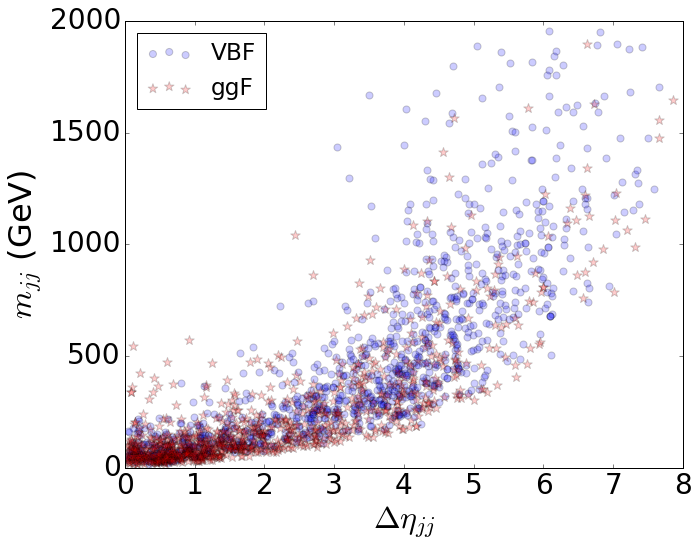

In [9]:
N = 1000
plotData(sig_train[:N], bkg_train[:N])

### Prepare data for training/testing and save to file
  * Concatenate training sig and bkg data, randomly shuffle rows
  * Extract two columns for inputs $X$ and targets for $y$ for both training and test data
  * Save training and test data using joblib

In [10]:
# create a randomly shuffled array of indices of size 2*N for training data
N = 25000
index = np.random.permutation(2*N)

# use the iloc method to randomly shuffle the ordinal values of the rows
train_data = pd.concat([sig_train[:N], bkg_train[:N]]).iloc[index]
print train_data.shape

# create a randomly shuffled array of indices of size 2*N for test data
N = 5000
index = np.random.permutation(2*N)
test_data = pd.concat([sig_test[:N], bkg_test[:N]]).iloc[index]
print test_data.shape

# extract (detajj, massjj) for training
X_train = pd.DataFrame({'detajj': [], 
                        'massjj': []})
X_train['detajj'] = train_data['detajj']
X_train['massjj'] = train_data['massjj']

# ... and for testing
X_test  = pd.DataFrame({'detajj': [], 
                        'massjj': []})
X_test['detajj'] = test_data['detajj']
X_test['massjj'] = test_data['massjj']
print X_test.shape

# extract y data
y_train = train_data['target']
y_test  = test_data['target']

# save data to file
filename = 'hzz_vbf_ggf_data.pkl'
joblib.dump([train_data, test_data], filename)

(50000, 10)
(10000, 10)
(10000, 2)


['hzz_vbf_ggf_data.pkl']